Made on 29/05/2024 by Alistair Duffey

Branched from the plotting notebook for SW
this notebook calculates and plots the direct aerosol radiative forcing (following Ghan 2013) using the postprocessed all-sky and clean-sky fluxes. 



In [1]:
import os
import glob
import pandas as pd
import numpy as np
import logging
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cftime
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## below input is calculated in 01_flux_to_temp
## it maps from SW fluxes to long-term cooling
conversion_rsdscs_T = -3.16 # [W/m2 per °C]

In [2]:
def get_ds(run, var):
    path = '/gws/nopw/j04/moghli/postprocessed_ncs/{r}/{v}/'.format(r=run, v=var)
    ds_list = []
    for file in os.listdir(path):
        ds_list.append(xr.open_dataset(path+file))
    ds = xr.concat(ds_list, dim='time').sortby('time')
    return ds


In [3]:
run_dict = {'u-dg683':[30.625, 12.3],
            'u-df777':[30.625, 12.9],
            'u-de348':[30.625, 14.1],
            'u-de517':[30.625, 15.4],
            'u-de349':[30.625, 16.0],
            'u-de350':[30.625, 18.0],
            'u-de365':[30.625, 20.2],
            'u-de110':[40.625, 12.3],
            'u-de636':[40.625, 12.9],
            'u-de111':[40.625, 14.1],
            'u-de505':[40.625, 15.4],
            'u-de145':[40.625, 16.0],
            'u-de187':[40.625, 18.0],
            'u-de369':[40.625, 20.2],
            'u-dd987':[50.625, 12.3],
            'u-de593':[50.625, 12.9],
            'u-dd989':[50.625, 14.1],
            'u-de506':[50.625, 15.4],
            'u-de012':[50.625, 16.0],
            'u-de013':[50.625, 18.0],
            'u-de399':[50.625, 20.2],
            'u-de018':[60.625, 12.3],
            'u-de567':[60.625, 12.9],
            'u-de026':[60.625, 14.1],
            'u-de633':[60.625, 15.4],
            'u-de050':[60.625, 16.0],
            'u-de052':[60.625, 18.0],
            'u-de457':[60.625, 20.2],
            'u-dg027':[70.625, 12.3],
            'u-df710':[70.625, 12.9],
            'u-dg309':[70.625, 14.1],
            'u-dg028':[70.625, 15.4],
            'u-dg549':[70.625, 16.0],
            'u-dg552':[70.625, 18.0],
            'u-dg655':[70.625, 20.2],
            'u-df848':[60.625, 12.9, 'Spring'],
            'u-df859':[60.625, 12.9, 'Summer'],
            'u-df931':[60.625, 12.9, 'Autumn'],
            'u-df932':[60.625, 12.9, 'Winter'],
            'u-dg051':[60.625, 12.9, 'Jan-Jun/Jul-Dec'],
            'u-dg331':[60.625, 12.9, 'Mar-Aug/Sep-Feb'],
            'u-dg381':[30.625, 15.4, 'Mar-Aug/Sep-Feb']
            }

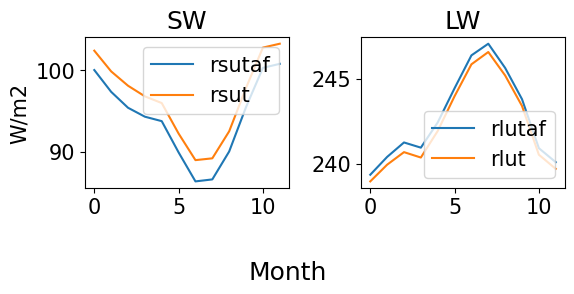

In [4]:
# get ssp245 first:

def get_ssp245_ds_r1(variable, table='Amon', grid='gn'):
    path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/{t}/{v}/{g}/latest/'.format(t=table,v=variable, g=grid)
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc')).sel(time='2036')
    ds = ds.rename({'x':'longitude',
                    'y':'latitude'})
    weights = np.cos(np.deg2rad(ds['latitude']))
    ds_ts = ds.mean(dim='longitude').weighted(weights).mean(dim='latitude')
    return ds, ds_ts

rsut_ssp245, rsut_ssp245_ts = get_ssp245_ds_r1(variable='rsut', table='Amon', grid='gn')
rlut_ssp245, rlut_ssp245_ts = get_ssp245_ds_r1(variable='rlut', table='Amon', grid='gn')

rsutaf_ssp245, rsutaf_ssp245_ts = get_ssp245_ds_r1(variable='rsutaf', table='AERmon', grid='gn')
rlutaf_ssp245, rlutaf_ssp245_ts = get_ssp245_ds_r1(variable='rlutaf', table='AERmon', grid='gn')

rsdscs_ssp245, rsdscs_ssp245_ts = get_ssp245_ds_r1(variable='rsdscs', table='Amon', grid='gn')

# also merge into one spatial ds:
ds_ssp245 = xr.merge([rsut_ssp245, rlut_ssp245, rsutaf_ssp245, rlutaf_ssp245, rsdscs_ssp245])
ds_ssp245['aerDirectForcing_SW'] = ds_ssp245['rsutaf'] - ds_ssp245['rsut']
ds_ssp245['aerDirectForcing_LW'] = ds_ssp245['rlutaf'] - ds_ssp245['rlut']
ds_ssp245['aerDirectForcing'] = ds_ssp245['aerDirectForcing_SW'] + ds_ssp245['aerDirectForcing_LW']

weights = np.cos(np.deg2rad(ds_ssp245['latitude']))
ds_ssp245_ts = ds_ssp245.mean(dim='longitude').weighted(weights).mean(dim='latitude')

## and check it looks reasonable:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
ax = axs[0]
ax.plot(rsutaf_ssp245_ts.rsutaf.values, label='rsutaf')
ax.plot(rsut_ssp245_ts.rsut.values, label='rsut')
ax.legend()
ax.set_title('SW')
ax.set_ylabel('W/m2')

ax = axs[1]
ax.plot(rlutaf_ssp245_ts.rlutaf.values, label='rlutaf')
ax.plot(rlut_ssp245_ts.rlut.values, label='rlut')
ax.legend()
ax.set_title('LW')
fig.supxlabel('Month')
plt.tight_layout()

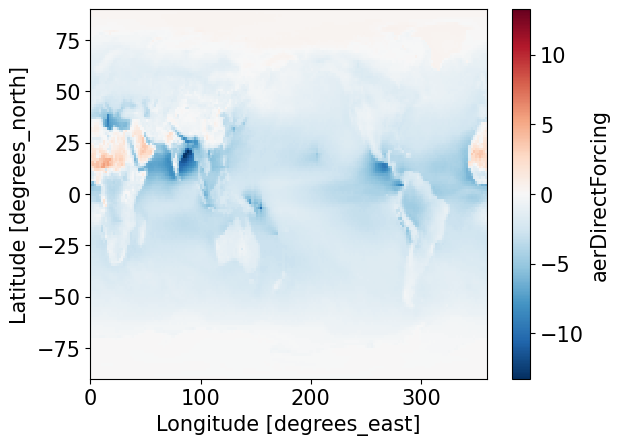

In [5]:
## also check spatially:
ds_ssp245['aerDirectForcing'].mean(dim='time').plot()

In [6]:
ds_list = []
#da_list = []
run_list = []
for run in run_dict.keys():
    #print(run)
    run_list.append(run)
    ds1 = get_ds(run, 'RadFluxes')
    ds1 = ds1.rename({'outgoing SW flux TOA':'rsut',
                      'outgoing_LW_rad_flux_TOA':'rlut'})
    ds1['injection_latitude'] = run_dict[run][0]
    ds1['injection_altitude'] = run_dict[run][1]
    ds1 = ds1.sel(time='2036')

    ds2 = get_ds(run, 'TOAFluxesUpCleanSky')
    ds2 = ds2.rename({'clean-air_upward_SW_flux_levels':'rsutaf',
                      'clean-air_upward_LW_flux_levels':'rlutaf'})
    ds2['injection_latitude'] = run_dict[run][0]
    ds2['injection_altitude'] = run_dict[run][1]
    ds2 = ds2.sel(time='2036')

    ds = xr.merge([ds1, ds2])
    ds['aerDirectForcing_SW'] = ds['rsutaf'] - ds['rsut']
    ds['aerDirectForcing_LW'] = ds['rlutaf'] - ds['rlut']
    ds['aerDirectForcing'] = ds['aerDirectForcing_SW'] + ds['aerDirectForcing_LW']
    ds_list.append(ds.mean(dim=['longitude']))
    
ds_dict = dict(zip(run_list, ds_list))

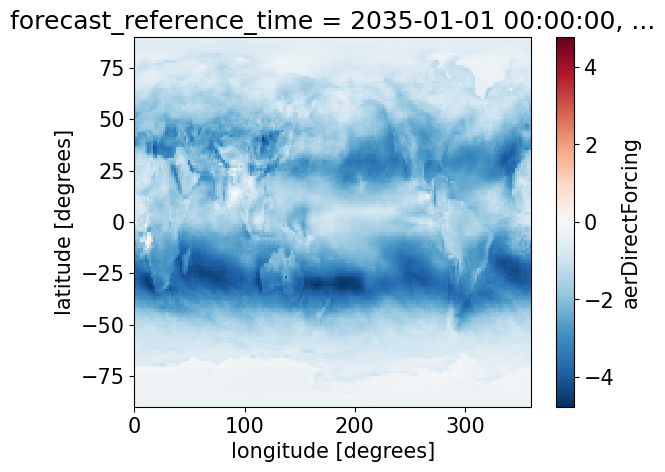

In [7]:
# check spatially:
(ds['aerDirectForcing'].mean(dim='time')-ds_ssp245['aerDirectForcing'].mean(dim='time')).plot()

In [8]:
### make a dataframe of global mean vars:
SW_forcings, LW_forcings, SW_forcing_deltas, LW_forcing_deltas, injection_lats, injection_alts = [], [], [], [], [], []
forcings, forcing_deltas = [], []
rsdscs_deltas, coolings = [], []
seasonals, seasonalitys = [], []

for run in run_list:
    ds = ds_dict[run]
    d = ds.mean('time')
    
    weights = np.cos(np.deg2rad(d['latitude']))
    d = d.weighted(weights).mean()

    SW_forcing = d.aerDirectForcing_SW.values.item()
    LW_forcing = d.aerDirectForcing_LW.values.item()
    forcing = d.aerDirectForcing.values.item()

    SW_forcing_delta = SW_forcing - ds_ssp245_ts.mean('time').aerDirectForcing_SW.values.item()
    LW_forcing_delta = LW_forcing - ds_ssp245_ts.mean('time').aerDirectForcing_LW.values.item()
    forcing_delta = forcing - ds_ssp245_ts.mean('time').aerDirectForcing.values.item()

    rsdscs_delta = d.rsdscs.values.item() - ds_ssp245_ts.mean('time').rsdscs.values.item()
    estimated_cooling = rsdscs_delta/conversion_rsdscs_T
    
    injection_lats.append(ds.injection_latitude.values.item())
    injection_alts.append(ds.injection_altitude.values.item())

    SW_forcings.append(SW_forcing)
    LW_forcings.append(LW_forcing)
    forcings.append(forcing)

    SW_forcing_deltas.append(SW_forcing_delta)
    LW_forcing_deltas.append(LW_forcing_delta)
    forcing_deltas.append(forcing_delta)

    rsdscs_deltas.append(rsdscs_delta)
    coolings.append(estimated_cooling)
    
    if len(run_dict[run])>2:
        seasonal = 'Yes'
        seasonality = run_dict[run][2]
    else:
        seasonal = 'No'
        seasonality = np.nan
    seasonals.append(seasonal)
    seasonalitys.append(seasonality)
    
    
DF = pd.DataFrame({'Run_ID':run_list,
                   'Injection_latitude':injection_lats,
                   'Injection_altitude':injection_alts,
                   'Seasonal':seasonals,
                   'Seasonality':seasonalitys,
                   'aerDirectForcing_SW':SW_forcings,
                   'aerDirectForcing_LW':LW_forcings,
                   'aerDirectForcing':forcings,
                   'Delta_aerDirectForcing_SW':SW_forcing_deltas,
                   'Delta_aerDirectForcing_LW':LW_forcing_deltas,
                   'Delta_aerDirectForcing':forcing_deltas,
                   'Delta_rsdscs':rsdscs_deltas,
                   'Cooling':coolings
                   })

DF.to_csv('Intermediate_outputs/TOA_forcings.csv')

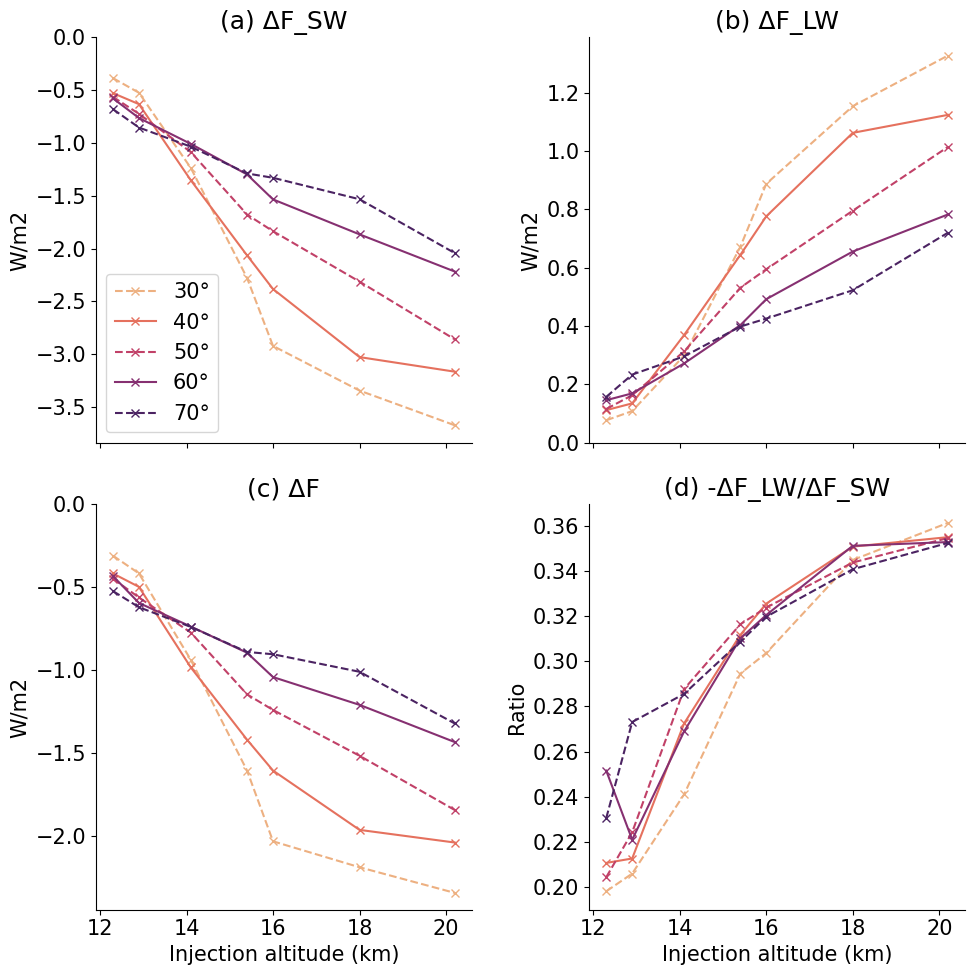

In [9]:
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))

fig, axs = plt.subplots(figsize=(10, 10), 
                        nrows=2, ncols=2,
                        #sharey='row',
                        sharex='col')

DF['Forcing_ratio_LW_to_SW'] = -DF['Delta_aerDirectForcing_LW']/DF['Delta_aerDirectForcing_SW']

vars = ['Delta_aerDirectForcing_SW', 'Delta_aerDirectForcing_LW',
        'Delta_aerDirectForcing', 'Forcing_ratio_LW_to_SW']

DF_ns = DF[DF['Seasonal']=='No']

i=0

titles=['(a) \u0394F_SW', '(b) \u0394F_LW', '(c) \u0394F', '(d) -\u0394F_LW/\u0394F_SW']
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']
for ax in axs.flatten():
    var=vars[i]    
    j=0
    for injection_lat in DF_ns['Injection_latitude'].unique():
        df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
        ax.plot(df_to_plot['Injection_altitude'], df_to_plot[var], 
                 marker='x', label=str(str(injection_lat).split('.')[0]+'°'),
                 c = palette[j], ls=linestyles[j])
        j=j+1
    if i in [2, 3]:
        ax.set_xlabel('Injection altitude (km)')
    ax.set_title(titles[i])
    ax.spines[['right', 'top']].set_visible(False)
    if i==0:
        ax.legend()
    if i in [0, 1, 2]:
        ax.set_ylabel('W/m2')
    if i == 3:
        ax.set_ylabel('Ratio')
       
    if i in [0, 2]:
        ax.set_ylim(top=0)
    if i ==1:
         ax.set_ylim(0,)
    i=i+1 
    
plt.tight_layout()
#plt.savefig('Figures/Scatters/TOA_forcings_lines.jpg', dpi=350, bbox_inches='tight')

In [10]:
DF[DF['Run_ID']=='u-df710']

,Run_ID,Injection_latitude,Injection_altitude,Seasonal,Seasonality,aerDirectForcing_SW,aerDirectForcing_LW,aerDirectForcing,Delta_aerDirectForcing_SW,Delta_aerDirectForcing_LW,Delta_aerDirectForcing,Delta_rsdscs,Cooling,Forcing_ratio_LW_to_SW
29,u-df710,70.625,12.9,No,NaN,-3.31885,0.699166,-2.619683,-0.854024,0.233194,-0.62083,-1.555911,0.492377,0.273053


In [11]:
DF[DF['Run_ID']=='u-de567']

,Run_ID,Injection_latitude,Injection_altitude,Seasonal,Seasonality,aerDirectForcing_SW,aerDirectForcing_LW,aerDirectForcing,Delta_aerDirectForcing_SW,Delta_aerDirectForcing_LW,Delta_aerDirectForcing,Delta_rsdscs,Cooling,Forcing_ratio_LW_to_SW
22,u-de567,60.625,12.9,No,NaN,-3.228669,0.634761,-2.593908,-0.763843,0.168789,-0.595054,-1.503558,0.475809,0.220973


In [12]:
DF[DF['Run_ID']=='u-de365']

,Run_ID,Injection_latitude,Injection_altitude,Seasonal,Seasonality,aerDirectForcing_SW,aerDirectForcing_LW,aerDirectForcing,Delta_aerDirectForcing_SW,Delta_aerDirectForcing_LW,Delta_aerDirectForcing,Delta_rsdscs,Cooling,Forcing_ratio_LW_to_SW
6,u-de365,30.625,20.2,No,NaN,-6.137983,1.792732,-4.34525,-3.673157,1.32676,-2.346397,-5.02228,1.589329,0.361204


In [13]:
# ratio of forcings for 70°/13km injeciton for 30°/20 km injection:
run = 'u-df710'
print(run_dict[run])
print(DF[DF['Run_ID']=='u-df710']['Delta_aerDirectForcing'].item())
print(100*(DF[DF['Run_ID']=='u-df710']['Delta_aerDirectForcing'].item()/DF[DF['Run_ID']=='u-de365']['Delta_aerDirectForcing'].item()))

[70.625, 12.9]
-0.6208295547794034
26.458849268783375


In [14]:
# ratio of forcings for 60°/13km/spring-summer injeciton for 30°/20 km injection:
run = 'u-dg331'
print(run_dict[run])
print(DF[DF['Run_ID']=='u-dg331']['Delta_aerDirectForcing'].item())
print(100*(DF[DF['Run_ID']=='u-dg331']['Delta_aerDirectForcing'].item()/DF[DF['Run_ID']=='u-de365']['Delta_aerDirectForcing'].item()))

[60.625, 12.9, 'Mar-Aug/Sep-Feb']
-0.8273782455753018
35.26165292779264


In [15]:
# ratio of forcings for 60°/13km/spring injeciton for 30°/20 km injection:
run ='u-df848'
print(run_dict[run])
print(DF[DF['Run_ID']==run]['Delta_aerDirectForcing'].item())
print(100*(DF[DF['Run_ID']==run]['Delta_aerDirectForcing'].item()/DF[DF['Run_ID']=='u-de365']['Delta_aerDirectForcing'].item()))

[60.625, 12.9, 'Spring']
-0.9311887943576505
39.68590696273113


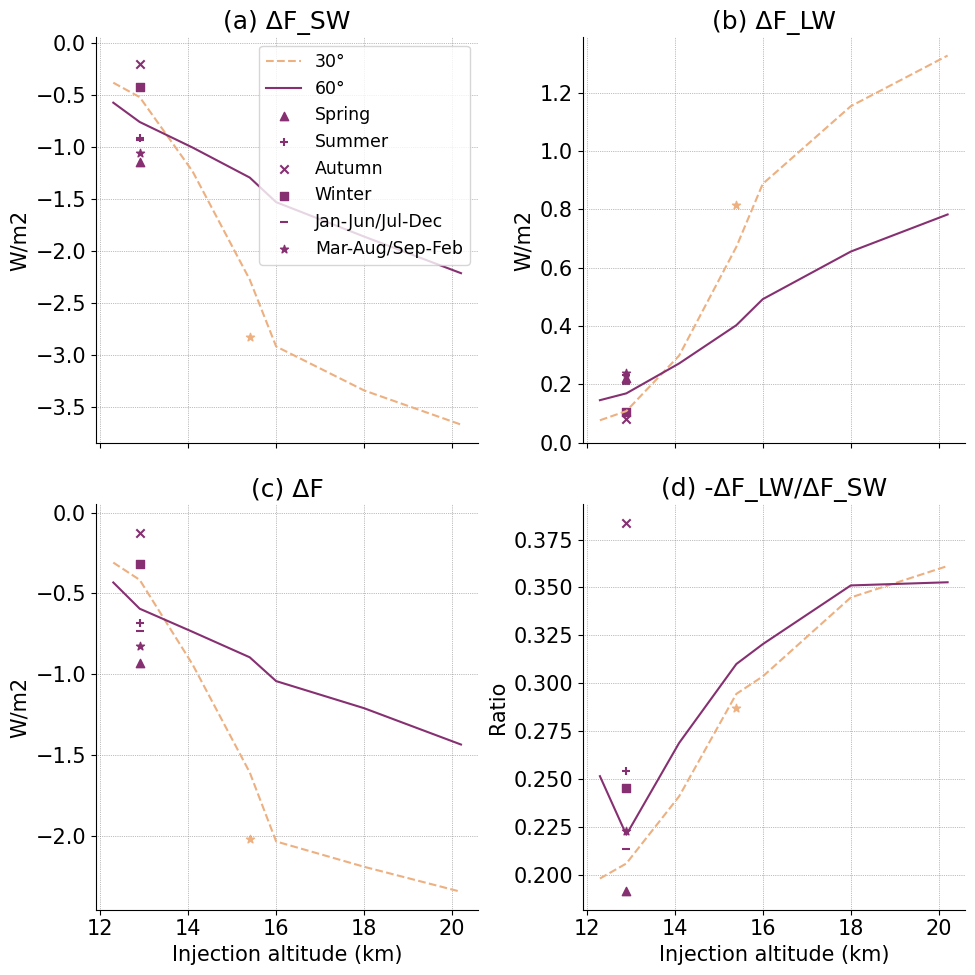

In [16]:
### repeat with seasonal runs added:
DF_s = DF[DF['Seasonal']=='Yes']
## v2
import seaborn as sns
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))

fig, axs = plt.subplots(figsize=(10, 10), 
                        nrows=2, ncols=2,
                        #sharey='row',
                        sharex='col')

vars = ['Delta_aerDirectForcing_SW', 'Delta_aerDirectForcing_LW',
        'Delta_aerDirectForcing', 'Forcing_ratio_LW_to_SW']
markers = ['^', '+', 'x', 's', '_', '*']

i=0

titles=['(a) \u0394F_SW', '(b) \u0394F_LW', '(c) \u0394F', '(d) -\u0394F_LW/\u0394F_SW']
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']
for ax in axs.flatten():
    var=vars[i]    
    j=0
    pal_positions = [0, 3]
    for injection_lat in [30.625, 60.625]:
        
        df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
        ax.plot(df_to_plot['Injection_altitude'], df_to_plot[var], 
                # marker='x',
                label=str(str(injection_lat).split('.')[0]+'°'),
                 c = palette[pal_positions[j]], ls=linestyles[j])
        j=j+1

    
    for injection_lat in DF_s['Injection_latitude'].unique():
        j=0
        for season in DF_s['Seasonality'].unique():
            df_to_plot = DF_s[DF_s['Injection_latitude']==injection_lat]
            df_to_plot = df_to_plot[df_to_plot['Seasonality']==season]
            if len(df_to_plot) > 0:
                if injection_lat == 60.625:
                    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                             marker=markers[j],
                             #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                             label='{}'.format(season),
                             c = palette[3])
                if injection_lat == 30.625:
                    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                             marker=markers[j],
                            #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                             c = palette[0])
            j=j+1

    
    if i in [2, 3]:
        ax.set_xlabel('Injection altitude (km)')
    ax.set_title(titles[i])
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
    ax.spines[['right', 'top']].set_visible(False)
    if i==0:
        ax.legend(ncols=1, fontsize='small', loc=1)
    if i in [0, 1, 2]:
        ax.set_ylabel('W/m2')
    if i == 3:
        ax.set_ylabel('Ratio')
       
    if i in [0, 2]:
        ax.set_ylim(top=0.05)
    if i ==1:
         ax.set_ylim(0,)
    i=i+1 
    
plt.tight_layout()
plt.savefig('Figures/Supp/TOA_forcings_lines_with_seasonal_3060.jpg', dpi=350, bbox_inches='tight')

In [17]:
## numbers for comment on increased efficiency for spring/summer injection

a = DF[DF['Run_ID']=='u-dg331']['Delta_aerDirectForcing'].item()
b = DF[DF['Run_ID']=='u-de567']['Delta_aerDirectForcing'].item()
print(a, b, (a-b)/b)

a = DF[DF['Run_ID']=='u-dg381']['Delta_aerDirectForcing'].item()
b = DF[DF['Run_ID']=='u-de517']['Delta_aerDirectForcing'].item()
print(a, b, (a-b)/b)

-0.8273782455753018 -0.5950543606113126 0.3904246407426
-2.021089764816635 -1.607863637192123 0.2570032172293822


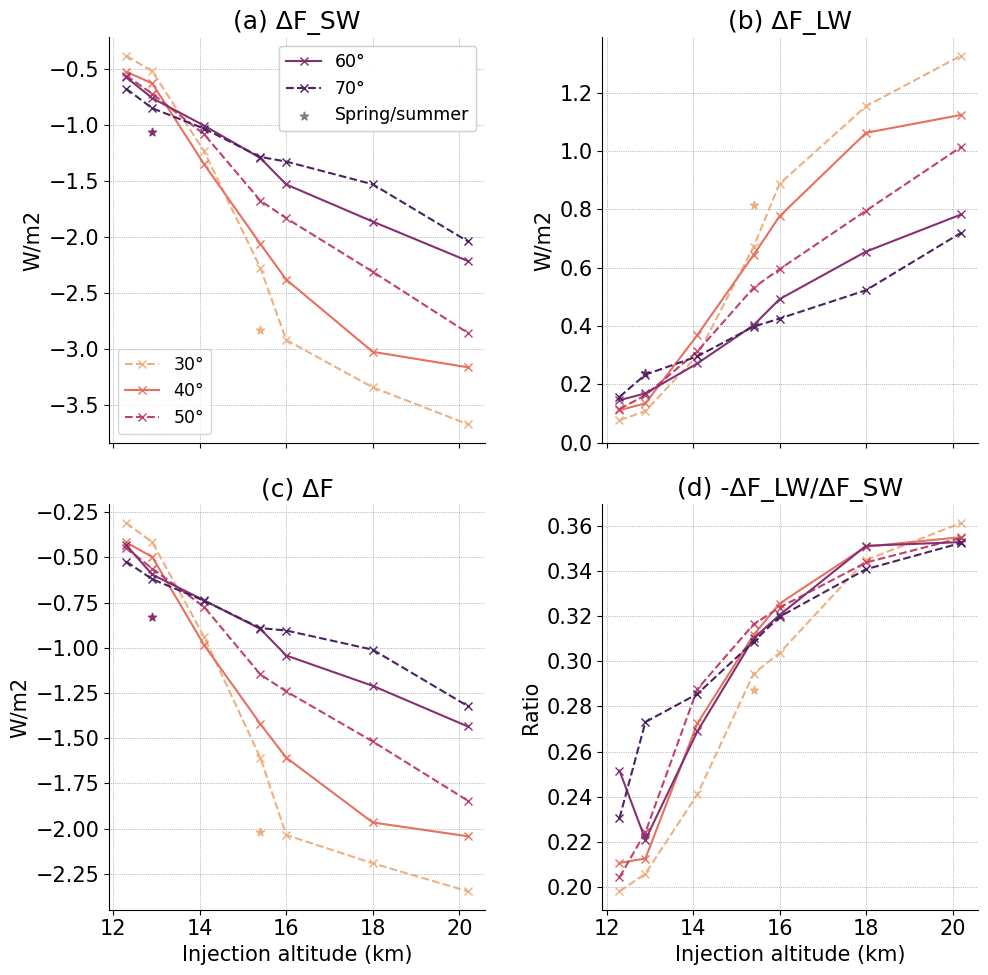

In [18]:
## v2
import seaborn as sns
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))

fig, axs = plt.subplots(figsize=(10, 10), 
                        nrows=2, ncols=2,
                        #sharey='row',
                        sharex='col')

DF['Forcing_ratio_LW_to_SW'] = -DF['Delta_aerDirectForcing_LW']/DF['Delta_aerDirectForcing_SW']

vars = ['Delta_aerDirectForcing_SW', 'Delta_aerDirectForcing_LW',
        'Delta_aerDirectForcing', 'Forcing_ratio_LW_to_SW']

DF_ns = DF[DF['Seasonal']=='No']

i=0

titles=['(a) \u0394F_SW', '(b) \u0394F_LW', '(c) \u0394F', '(d) -\u0394F_LW/\u0394F_SW']
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']
for ax in axs.flatten():
    var=vars[i]    
    j=0
    for injection_lat in DF_ns['Injection_latitude'].unique():
        df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
        ax.plot(df_to_plot['Injection_altitude'], df_to_plot[var], 
                 marker='x', label=str(str(injection_lat).split('.')[0]+'°'),
                 c = palette[j], ls=linestyles[j])
        j=j+1
    if i in [2, 3]:
        ax.set_xlabel('Injection altitude (km)')
    ax.set_title(titles[i])
    ax.spines[['right', 'top']].set_visible(False)

    for injection_lat in DF_s['Injection_latitude'].unique():
        j=0
        for season in ['Mar-Aug/Sep-Feb']:
            df_to_plot = DF_s[DF_s['Injection_latitude']==injection_lat]
            df_to_plot = df_to_plot[df_to_plot['Seasonality']==season]
            if len(df_to_plot) > 0:
                if injection_lat == 60.625:
                    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                             marker='*',
                             #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                             #label='{}'.format(season),
                             c = palette[3])
                    sc = ax.scatter([], [], 
                             marker='*',
                             label='Spring/summer',
                             c = 'gray')
                if injection_lat == 30.625:
                    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                             marker='*',
                            #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                             c = palette[0])
            j=j+1
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
    if i==0:
        #ax.legend(loc='lower left', ncols=2, fontsize='small')
        legend1 = ax.legend(handles=[ax.lines[0], ax.lines[1], ax.lines[2]], 
                            loc='lower left', fontsize='small')
        ax.add_artist(legend1)
        legend2 = ax.legend(handles=[ax.lines[3], ax.lines[4], sc], 
                            loc='upper right', fontsize='small')
        ax.add_artist(legend2)
        
    if i in [0, 1, 2]:
        ax.set_ylabel('W/m2')
    if i == 3:
        ax.set_ylabel('Ratio')
       
    #if i in [0, 2]:
    #    ax.set_ylim(top=0)
    if i ==1:
         ax.set_ylim(0,)
    i=i+1 
    
plt.tight_layout()
plt.savefig('Figures/Main/TOA_forcings_lines_withSeasonal_v2.jpg', dpi=350, bbox_inches='tight')

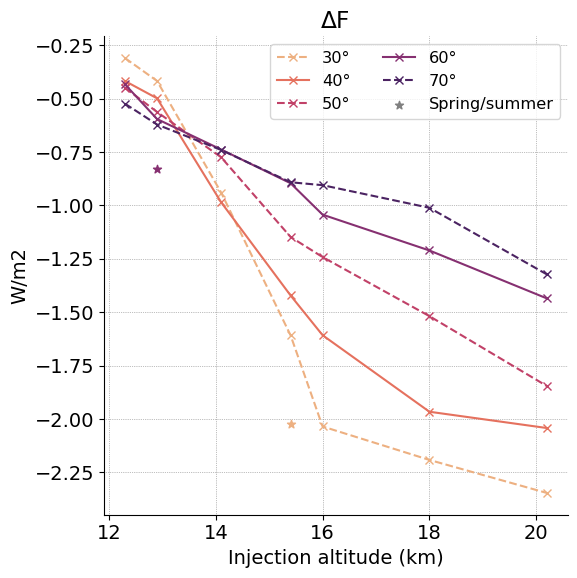

In [19]:
## just plot delta F
import seaborn as sns
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6, 6))

DF['Forcing_ratio_LW_to_SW'] = -DF['Delta_aerDirectForcing_LW']/DF['Delta_aerDirectForcing_SW']

vars = ['Delta_aerDirectForcing']

DF_ns = DF[DF['Seasonal']=='No']

i=0

titles=['\u0394F']
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']
var=vars[i]    
j=0
for injection_lat in DF_ns['Injection_latitude'].unique():
    df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
    ax.plot(df_to_plot['Injection_altitude'], df_to_plot[var], 
             marker='x', label=str(str(injection_lat).split('.')[0]+'°'),
             c = palette[j], ls=linestyles[j])
    j=j+1

ax.set_xlabel('Injection altitude (km)')
ax.set_title(titles[i])
ax.spines[['right', 'top']].set_visible(False)

for injection_lat in DF_s['Injection_latitude'].unique():
    j=0
    for season in ['Mar-Aug/Sep-Feb']:
        df_to_plot = DF_s[DF_s['Injection_latitude']==injection_lat]
        df_to_plot = df_to_plot[df_to_plot['Seasonality']==season]
        if len(df_to_plot) > 0:
            if injection_lat == 60.625:
                ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                         marker='*',
                         #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                         #label='{}'.format(season),
                         c = palette[3])
                ax.scatter([], [], 
                         marker='*',
                         label='Spring/summer',
                         c = 'gray')
            if injection_lat == 30.625:
                ax.scatter(df_to_plot['Injection_altitude'], df_to_plot[var], 
                         marker='*',
                        #label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                         c = palette[0])
        j=j+1
ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
ax.legend(loc='upper right', ncols=2, fontsize='small')
ax.set_ylabel('W/m2')
#ax.set_ylim(0,)
    
plt.tight_layout()
plt.savefig('Figures/Extra/TOA_forcings_lines_justTotal.jpg', dpi=350, bbox_inches='tight')

In [20]:
df_to_plot = DF_s[DF_s['Injection_latitude']==60.625]
df_to_plot = df_to_plot[df_to_plot['Seasonality']=='Mar-Aug/Sep-Feb']
x = df_to_plot['Delta_aerDirectForcing'].item()

df_to_plot = DF[DF['Injection_latitude']==30.625]
df_to_plot = df_to_plot[df_to_plot['Injection_altitude']==20.2]
y = df_to_plot['Delta_aerDirectForcing'].item()
print(x)
print(x/y)

df_to_plot = DF[DF['Injection_latitude']==60.625]
df_to_plot = df_to_plot[df_to_plot['Injection_altitude']==12.9]
df_to_plot = df_to_plot[df_to_plot['Seasonal']=='No']
z = df_to_plot['Delta_aerDirectForcing'].item()
print(z)

-0.8273782455753018
0.35261652927792636
-0.5950543606113126


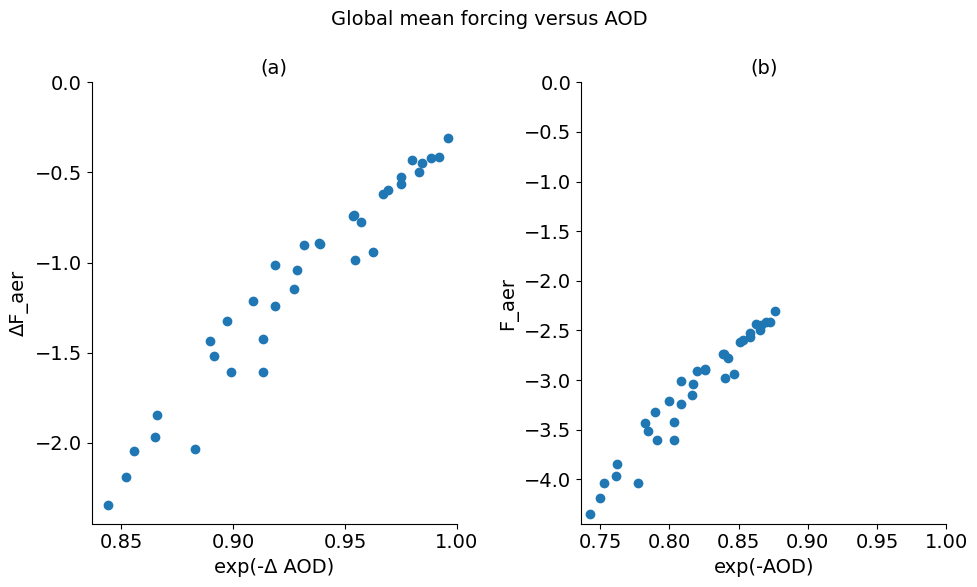

In [21]:
## let's check the relationship between forcing and AOD:

AOD_DF = pd.read_csv('Intermediate_outputs/AOD_all_sims.csv').drop(['Injection_latitude', 'Injection_altitude'], axis=1)
DF_all = pd.merge(DF, AOD_DF, on='Run_ID', how='left').dropna(subset='sAOD')
DF_all['Forcing_per_unit_AOD'] = DF_all['Delta_aerDirectForcing']/DF_all['delta_AOD']

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
titles = ['(a)', '(b)']

ax = axs[0]
ax.scatter(np.exp(-DF_all['delta_AOD']), DF_all['Delta_aerDirectForcing'])
#ax.scatter(-DF_all['delta_AOD'], DF_all['Delta_aerDirectForcing'])

ax.set_ylim(top=0)
ax.set_xlim(right=1)
ax.set_xlabel('exp(-\u0394 AOD)')
ax.set_ylabel('\u0394F_aer')

ax = axs[1]
ax.scatter(np.exp(-DF_all['AOD']), DF_all['aerDirectForcing'])
ax.set_ylim(top=0)
ax.set_xlim(right=1)
ax.set_xlabel('exp(-AOD)')
ax.set_ylabel('F_aer')

i=0
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title(titles[i], fontsize='medium')
    i=i+1

fig.suptitle('Global mean forcing versus AOD', fontsize='medium')
plt.tight_layout()
plt.savefig('Figures/Extra/Forcing_vs_AOD.jpg', dpi=350)

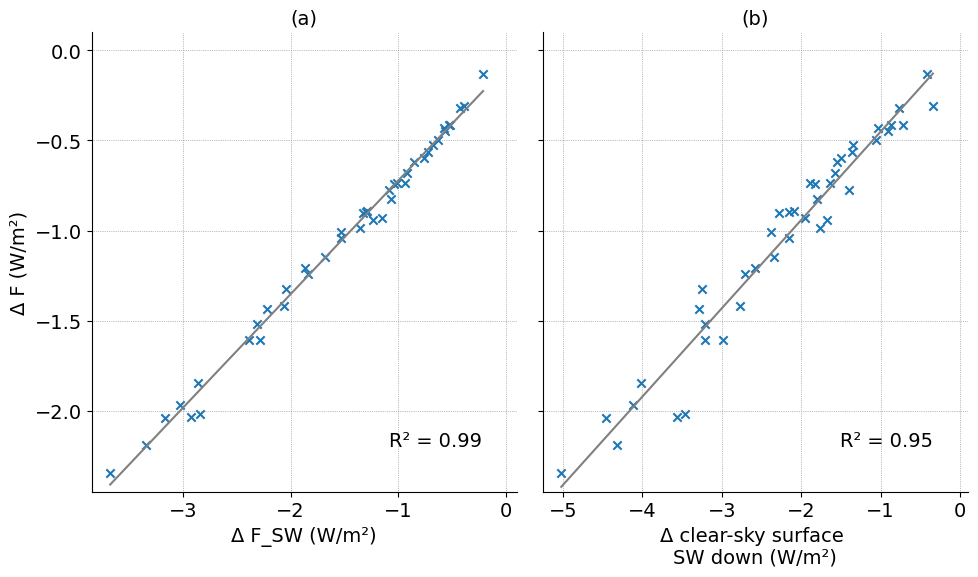

In [29]:
## SUPP fig to show that across my sims, total F is proportional to F_SW and delta rsdscs

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)


x_vars = ['Delta_aerDirectForcing_SW', 'Delta_rsdscs']
y_vars = ['Delta_aerDirectForcing', 'Delta_aerDirectForcing']
x_labels = ['\u0394 F_SW (W/m\u00b2)', 'Δ clear-sky surface \nSW down (W/m\u00b2)']
y_labels = ['\u0394 F (W/m\u00b2)', '\u0394 F (W/m\u00b2)']
titles = ['(a)', '(b)']

i=0
for ax in axs:
    x_var, y_var = x_vars[i], y_vars[i]
    x_label, y_label = x_labels[i], y_labels[i]
    
    ax.scatter(DF[x_var], DF[y_var], marker='x')
    lr = stats.linregress(DF[x_var], DF[y_var])
    xs = np.arange(np.min(DF[x_var]), np.max(DF[x_var]), 0.01)
    ax.plot(xs, lr.intercept + lr.slope*xs, c='gray')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylim(-2.45, 0.1)
    ax.set_xlim(None, 0.1)
    if i ==0:
        ax.set_ylabel(y_label)
    ax.text(0.7, 0.1, str('R\u00b2 = '+str(np.round(lr.rvalue**2, 2))), transform=ax.transAxes)
    ax.set_title(titles[i], fontsize='medium')
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)

    i=i+1

#fig.suptitle('\u0394 F_SW and \u0394 rsdscs both good proxies for total \u0394 F', fontsize='medium')
plt.tight_layout()
plt.savefig('Figures/Supp/rsdscs_and_F_SW_vs_F_total_over_all_test_sims.jpg', dpi=350)

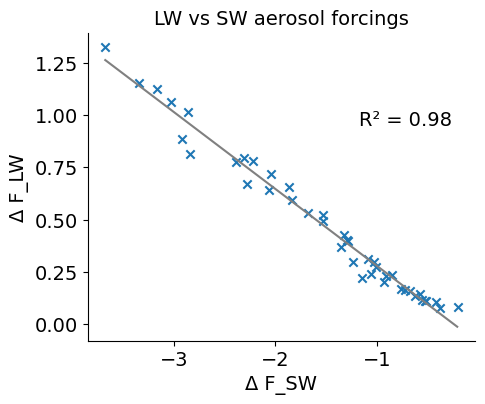

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
x_var, y_var = 'Delta_aerDirectForcing_SW', 'Delta_aerDirectForcing_LW'
ax.scatter(DF[x_var], DF[y_var], marker='x')
lr = stats.linregress(DF[x_var], DF[y_var])
xs = np.arange(np.min(DF[x_var]), np.max(DF[x_var]), 0.01)
ax.plot(xs, lr.intercept + lr.slope*xs, c='gray')
ax.set_title('LW vs SW aerosol forcings', fontsize='medium')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('\u0394 F_SW')
ax.set_ylabel('\u0394 F_LW')
ax.text(0.7, 0.7, str('R\u00b2 = '+str(np.round(lr.rvalue**2, 2))), transform=ax.transAxes)
plt.savefig('Figures/Extra/LW_vs_SW_aerosol_forcings.jpg', dpi=350)

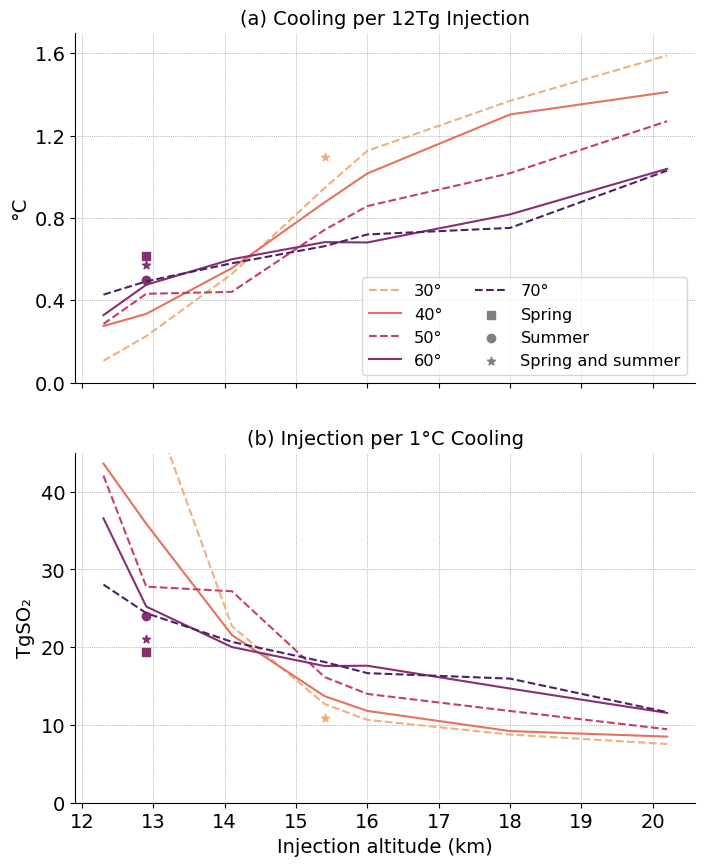

In [24]:
### now plot the estimated cooling and injection for 1C based on delta rsdscs:

fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']


ax = axs[0]
i=0
for injection_lat in DF_ns['Injection_latitude'].unique():
    df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
    ax.plot(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
             #marker='x', 
             label=str(str(injection_lat).split('.')[0]+'°'),
             ls = linestyles[i],
             c = palette[i])
    i=i+1

ax.set_ylim(0, 1.7)
ax.set_ylabel('°C')
ax.set_title('(a) Cooling per 12Tg Injection', fontsize='medium')

markers = ['s', 'o', '*']
i=0
for season in ['Spring', 'Summer']:
    df_to_plot = DF_s[DF_s['Seasonality']==season]
    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[i], 
               #label=season,
               c = palette[3])
    i=i+1
df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==60.625]
ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[3])

ax.scatter([], [], marker=markers[0], label='Spring', c = 'gray')
ax.scatter([], [], marker=markers[1], label='Summer', c = 'gray')
ax.scatter([], [], marker=markers[2], label='Spring and summer', c = 'gray')

df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==30.625]
ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[0])
ax.legend(ncol=2, fontsize='small')
ax.set_yticks(np.arange(0, 1.8, 0.4))

ax = axs[1]
i=0
for injection_lat in DF_ns['Injection_latitude'].unique():
    df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
    ax.plot(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
             #marker='x', 
             label=str(str(injection_lat).split('.')[0]+'°'),
             ls = linestyles[i],
             c = palette[i])
    i=i+1

i=0
for season in ['Spring', 'Summer']:
    df_to_plot = DF_s[DF_s['Seasonality']==season]
    ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[i], 
               label=season,
               c = palette[3])
    i=i+1
df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==60.625]
ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[2], 
               label='Spring and summer',
               c = palette[3])

df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==30.625]
ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[0])
ax.set_ylim(0, 45)
ax.set_yticks(np.arange(0, 50, 10))
ax.set_ylabel('TgSO\u2082')   
ax.set_title('(b) Injection per 1°C Cooling', fontsize='medium')
ax.set_xlabel('Injection altitude (km)')

axs[0].spines[['right', 'top']].set_visible(False)
axs[0].grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)

plt.savefig('Figures/Extra/Summary_cooling.jpg', dpi=350)

In [25]:
spring_60 = DF_s[DF_s['Seasonality']=='Spring']
cooling_spring_60 = spring_60['Cooling'].item()
cooling_spring_60
cooling_30_20 = DF[DF['Run_ID']=='u-de365']['Cooling'].item()
efficiency_ratio = cooling_spring_60/cooling_30_20
print(efficiency_ratio)

0.38837605043291645


In [26]:
springsummer_60 = DF_s[DF_s['Run_ID']=='u-dg331']
cooling_springsummer_60 = springsummer_60['Cooling'].item()
cooling_30_20 = DF[DF['Run_ID']=='u-de365']['Cooling'].item()
efficiency_ratio = cooling_springsummer_60/cooling_30_20
print(efficiency_ratio)

0.3590329273644206


In [27]:
df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==60.625]
print(12/(df_to_plot['Cooling']))

40    21.029702
Name: Cooling, dtype: float64


In [28]:
print(12/DF_ns[DF_ns['Run_ID']=='u-de365']['Cooling'])

6    7.550355
Name: Cooling, dtype: float64


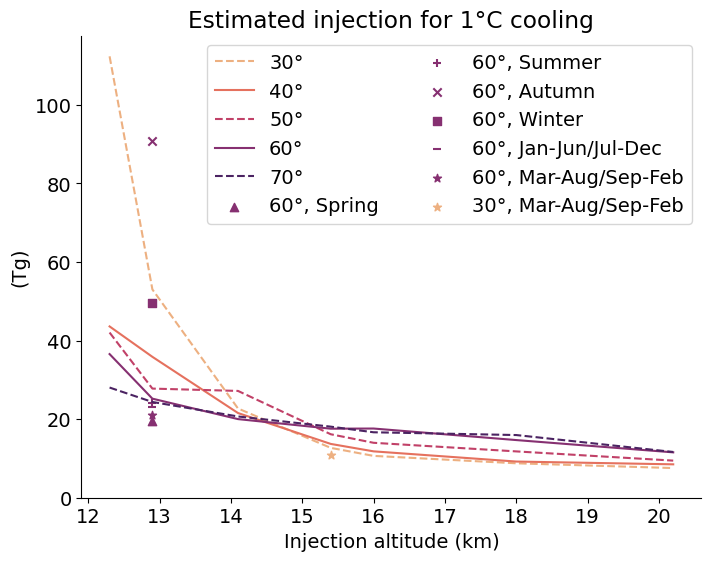

In [29]:
### now plot the estimated cooling and injection for 1C based on delta rsdscs:

fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']
i=0
for injection_lat in DF_ns['Injection_latitude'].unique():
    df_to_plot = DF_ns[DF_ns['Injection_latitude']==injection_lat]
    plt.plot(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
             #marker='x', 
             label=str(str(injection_lat).split('.')[0]+'°'),
             ls = linestyles[i],
             c = palette[i])
    i=i+1

#markers = ['^', '+', '_', 's']
markers = ['^', '+', 'x', 's', '_', '*']

for injection_lat in DF_s['Injection_latitude'].unique():
    j=0
    for season in DF_s['Seasonality'].unique():
        df_to_plot = DF_s[DF_s['Injection_latitude']==injection_lat]
        df_to_plot = df_to_plot[df_to_plot['Seasonality']==season]
        if len(df_to_plot) > 0:
            if injection_lat == 60.625:
                plt.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
                         marker=markers[j], label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                         c = palette[3])
            if injection_lat == 30.625:
                plt.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
                         marker=markers[j], label=str(str(injection_lat).split('.')[0]+'°, {}'.format(season)),
                         c = palette[0])
        j=j+1
        
plt.legend(ncol=2)
plt.ylim(0,)
plt.xlabel('Injection altitude (km)')
plt.ylabel('(Tg)')
plt.title('Estimated injection for 1°C cooling')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('Figures/Scatters/injection_per_1°C_cooling_lines_v2.jpg', dpi=350, bbox_inches='tight')

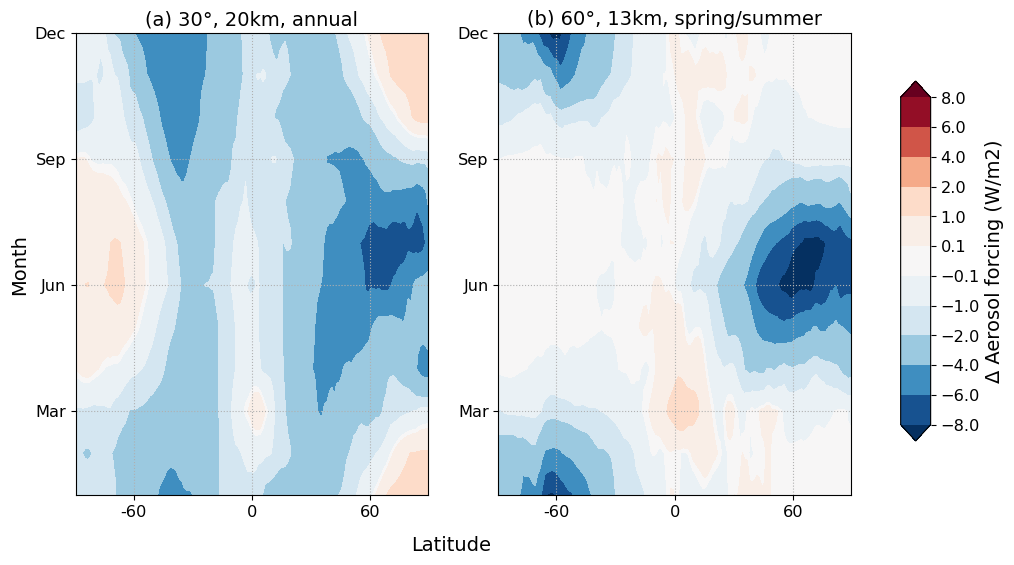

In [30]:
### also plot spatial forcings:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

i=0
titles=['(a) 30°, 20km, annual', '(b) 60°, 13km, spring/summer']
#for run in ['u-de365', 'u-dg331']:
for run in ['u-de365', 'u-df848']:
    ax = axs[i]
    ds = ds_dict[run]
    cs=ax.contourf(ds.latitude.values, ds.time.dt.month.values, 
                   ds.aerDirectForcing.values-ds_ssp245['aerDirectForcing'].mean('longitude').values,
                   #levels = np.arange(-8, 9, 2),
                   levels = [-8, -6, -4, -2, -1, -0.1, 0.1, 1, 2, 4, 6, 8],
                   #levels = [-7, -5, -3, -1, 1, 3, 5, 7],
                   #levels = [-7, -6, -5, -4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4, 5, 6, 7],
                   cmap='RdBu_r',
                   extend='both')
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    ax.set_yticks([3, 6, 9, 12])
    ax.set_yticklabels(['Mar', 'Jun', 'Sep', 'Dec'], fontsize='small')
    ax.grid(ls='dotted')
    ax.set_title(titles[i], fontsize='medium')
    i=i+1
    
axs[0].set_ylabel('Month')
fig.supxlabel('Latitude', fontsize='medium')

#cbar_ax1 = fig.add_axes([0.05, -0.05, 0.35, 0.04])
cbar_ax1 = fig.add_axes([0.95, 0.2, 0.03, 0.6])
cbar1 = fig.colorbar(cs, cax=cbar_ax1, orientation='vertical', 
                     label='\u0394 Aerosol forcing (W/m2)',
                     ticks=[-8, -6, -4, -2, -1, -0.1, 0.1, 1, 2, 4, 6, 8])
cbar1.ax.tick_params(labelsize='small')
plt.savefig('Figures/Main/zonal_seasonal_forcing.jpg', dpi=350, bbox_inches='tight')
plt.show()

In [31]:
# get grid cell areas for UKESM 
areacella = xr.open_dataset('/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/areacella/gn/latest/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')

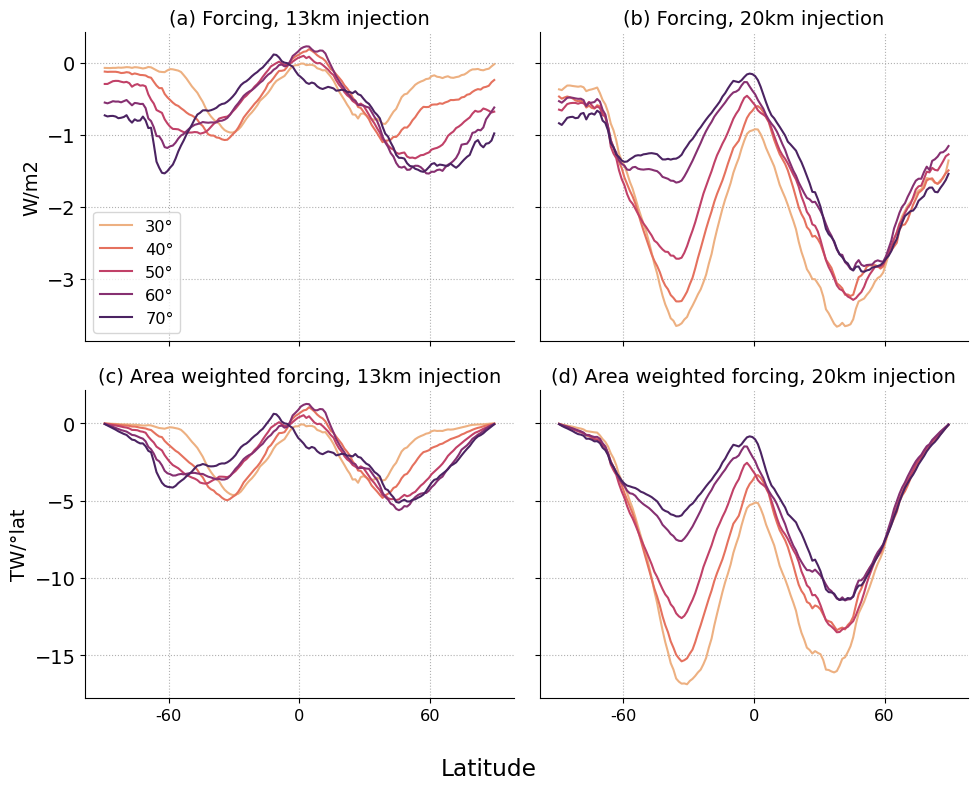

In [32]:
### add plot to show zonal shape of forcing across multiple scenarios in W/m2 and TW/deg lat


# also add a plot for the amplitude of the seasonal cycle in forcing:
fig, axs = plt.subplots(2, 2,figsize=(10, 8), sharex=True, sharey='row')
#cols=[palette[0], palette[3]]
#f_ylims = -11, 3

i=0
#labels=['30°, 20km, annual', '60°, 13km, spring/summer']
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']

runs_13km = [x for x in run_dict if run_dict[x][1] == 12.9 and len(run_dict[x])<3]
labels = [run_dict[x][0] for x in runs_13km]

for run in runs_13km:
    ax = axs.flatten()[0]
    ds = ds_dict[run]
    ax.plot(ds.aerDirectForcing.mean(dim='time').latitude.values, 
             ds.aerDirectForcing.mean(dim='time').values - ds_ssp245['aerDirectForcing'].mean(['time', 'longitude']).values, 
             label=str(int(np.floor(labels[i])))+'°',
             c=palette[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
#ax.set_ylim(f_ylims)
ax.set_title('(a) Forcing, 13km injection', fontsize='medium')
ax.grid(ls='dotted')
ax.legend(fontsize='small')
ax.set_ylabel('W/m2')

# also get the zonal integral
i=0
for run in runs_13km:
    ax = axs.flatten()[2]
    ds = ds_dict[run]
    mean = ds.aerDirectForcing.mean(dim='time') - ds_ssp245['aerDirectForcing'].mean(['time', 'longitude']).values
    area_weighted_forcing_TW = 1e-12 * mean.values * areacella.sum('lon').areacella.values
    ax.plot(mean.latitude.values, area_weighted_forcing_TW, 
            c=palette[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
ax.set_title('(c) Area weighted forcing, 13km injection', fontsize='medium')
ax.grid(ls='dotted')
ax.set_ylabel('TW/°lat')


runs_20km = [x for x in run_dict if run_dict[x][1] == 20.2 and len(run_dict[x])<3]
labels = [run_dict[x][0] for x in runs_20km]

i=0
for run in runs_20km:
    ax = axs.flatten()[1]
    ds = ds_dict[run]
    ax.plot(ds.aerDirectForcing.mean(dim='time').latitude.values, 
             ds.aerDirectForcing.mean(dim='time').values - ds_ssp245['aerDirectForcing'].mean(['time', 'longitude']).values, 
             label=labels[i], c=palette[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
#ax.set_ylim(f_ylims)
ax.set_title('(b) Forcing, 20km injection', fontsize='medium')
ax.grid(ls='dotted')
#ax.legend(fontsize='small')
#ax.set_ylabel('W/m2')

# also get the zonal integral
i=0
for run in runs_20km:
    ax = axs.flatten()[3]
    ds = ds_dict[run]
    mean = ds.aerDirectForcing.mean(dim='time') - ds_ssp245['aerDirectForcing'].mean(['time', 'longitude']).values
    area_weighted_forcing_TW = 1e-12 * mean.values * areacella.sum('lon').areacella.values
    ax.plot(mean.latitude.values, area_weighted_forcing_TW, 
            label=labels[i], c=palette[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
ax.set_title('(d) Area weighted forcing, 20km injection', fontsize='medium')
ax.grid(ls='dotted')
#ax.set_ylabel('TW/°lat')
for ax in axs.flatten():
    ax.spines[['right', 'top']].set_visible(False)

fig.supxlabel('Latitude')
plt.tight_layout()
plt.savefig('Figures/Main/zonal_seasonal_forcing_overview_13and20.jpg', dpi=350, bbox_inches='tight')
plt.show()


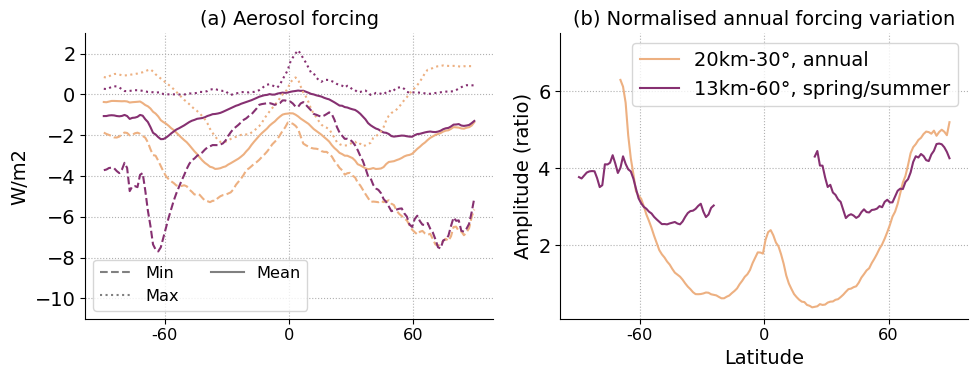

In [37]:

fig, axs = plt.subplots(1, 2,figsize=(10, 4))

cs=[palette[0], palette[3]]
f_ylims = -11, 3
ax=axs[0]
labels=['20km-30°, annual', '13km-60°, spring/summer']
i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.mean(dim='time').latitude.values, 
             delta_F.mean(dim='time').values, 
             c=cs[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
ax.set_ylim(f_ylims)
ax.set_title('(a) Aerosol forcing', fontsize='medium')
ax.grid(ls='dotted')
#ax.legend(fontsize='small')
ax.set_ylabel('W/m2')

i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.max(dim='time').latitude.values, 
             delta_F.max(dim='time').values, 
             c=cs[i], ls='dotted')
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    i=i+1
#ax.set_title('(b) Max forcing', fontsize='medium')
ax.grid(ls='dotted')
ax.set_ylabel('W/m2')

i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.min(dim='time').latitude.values, 
            delta_F.min(dim='time').values, 
            c=cs[i], ls='--')
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    ax.set_ylim(f_ylims)
    i=i+1
ax.grid(ls='dotted')
#ax.set_ylabel('W/m2')

ax.plot([], [], c='gray', ls='--', label='Min')
ax.plot([], [], c='gray', ls='dotted', label='Max')
ax.plot([], [], c='gray', label='Mean')
ax.legend(fontsize='small', ncols=2)




ax=axs[1]
i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    amplitude = -(delta_F.max(dim='time') - delta_F.min(dim='time'))/delta_F.mean(dim='time')
    # only define amplitude where forcing is negative (i.e. dont divide by zero):
    amplitude = amplitude.where(delta_F.mean(dim='time')<-0.5)
    ax.plot(amplitude.latitude.values, amplitude.values, label=labels[i], c=cs[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'], fontsize='small')
    #ax.set_yticks([3, 6, 9, 12])
    #ax.set_yticklabels(['Mar', 'Jun', 'Sep', 'Dec'], fontsize='small')
    i=i+1
ax.set_title('(b) Normalised annual forcing variation', fontsize='medium')
ax.grid(ls='dotted')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Amplitude (ratio)')
ax.set_ylim(None, 7.5)
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
#fig.supxlabel('Latitude')
plt.tight_layout()
plt.savefig('Figures/Extra/zonal_seasonal_forcing_cycle_amplitudes_v2.jpg', dpi=350, bbox_inches='tight')
plt.show()

In [38]:
# get ssp245 baseline aod:
path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/AERmon/od550aer/gn/latest/'
aod_ssp245_r1 = rename_cmip6(xr.open_mfdataset(path+'*.nc')).sel(time='2036')
aod_ssp245_r1 = aod_ssp245_r1.mean(dim=['x']).rename({'y':'latitude'}).mean('time')

In [39]:
### also add a scatter of the centroid of AOD, forcing, area-weighted forcing:

centroids_Fs, centroids_AFs, centroids_AODs = [], [], []
centroids_Fs_SH, centroids_AFs_SH, centroids_AODs_SH = [], [], []

runs = ['u-de365', 'u-dg331']
for run in runs:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude')).mean('time')
    delta_F_area_weighted_TW_vals = 1e-12 * delta_F.values * areacella.sum('lon').areacella.values
    delta_F_area_weighted_TW = delta_F.copy()
    delta_F_area_weighted_TW.values = delta_F_area_weighted_TW_vals
    
    aod = get_ds(run, 'AOD').mean(['longitude','time'])
    aod_da = aod.Total_AOD.copy()
    aod_vals = aod.Total_AOD - aod_ssp245_r1.od550aer.values
    aod_da.values = aod_vals
    
    def get_centroids(da):
        NH_da = da.sel(latitude=slice(0, 90))
        SH_da = da.sel(latitude=slice(-90, 0))
        return NH_da.latitude.weighted(NH_da).mean().values.item(), SH_da.latitude.weighted(SH_da).mean().values.item(), 
    
    centroids_F = get_centroids(delta_F)
    centroids_AF = get_centroids(delta_F_area_weighted_TW)
    centroids_AOD = get_centroids(aod_da)
    
    centroids_Fs.append(centroids_F[0])
    centroids_AFs.append(centroids_AF[0])
    centroids_AODs.append(centroids_AOD[0])

    centroids_Fs_SH.append(centroids_F[1])
    centroids_AFs_SH.append(centroids_AF[1])
    centroids_AODs_SH.append(centroids_AOD[1])

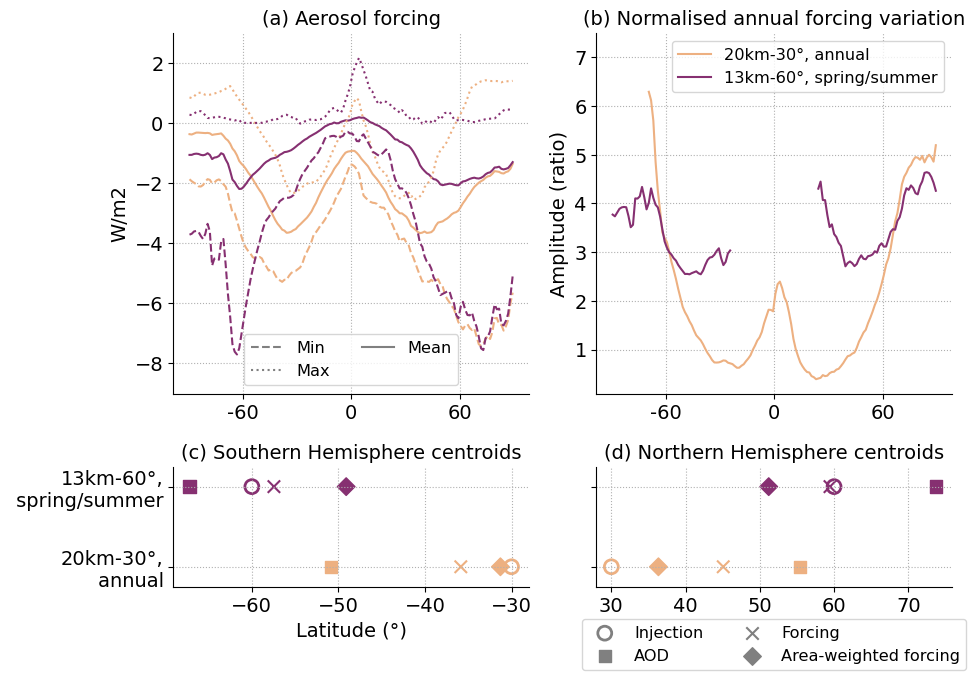

In [40]:
fig, axs = plt.subplots(2, 2,figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

ax=axs.flatten()[0]
labels=['20km-30°, annual', '13km-60°, spring/summer']
f_ylims = [-9, 3]
i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.mean(dim='time').latitude.values, 
             delta_F.mean(dim='time').values, 
             c=cs[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'])
    i=i+1
ax.set_ylim(f_ylims)
ax.set_title('(a) Aerosol forcing', fontsize='medium')
ax.grid(ls='dotted')
#ax.legend(fontsize='small')
ax.set_ylabel('W/m2')

i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.max(dim='time').latitude.values, 
             delta_F.max(dim='time').values, 
             c=cs[i], ls='dotted')
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'])
    i=i+1
#ax.set_title('(b) Max forcing', fontsize='medium')
ax.grid(ls='dotted')
ax.set_ylabel('W/m2')

i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    ax.plot(delta_F.min(dim='time').latitude.values, 
            delta_F.min(dim='time').values, 
            c=cs[i], ls='--')
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'])
    ax.set_ylim(f_ylims)
    i=i+1
ax.grid(ls='dotted')
#ax.set_ylabel('W/m2')

ax.plot([], [], c='gray', ls='--', label='Min')
ax.plot([], [], c='gray', ls='dotted', label='Max')
ax.plot([], [], c='gray', label='Mean')
ax.legend(fontsize='small', ncols=2)

ax=axs.flatten()[1]
i=0
for run in ['u-de365', 'u-dg331']:
    ds = ds_dict[run]
    delta_F = (ds.aerDirectForcing - ds_ssp245['aerDirectForcing'].mean('longitude'))
    amplitude = -(delta_F.max(dim='time') - delta_F.min(dim='time'))/delta_F.mean(dim='time')
    # only define amplitude where forcing is negative (i.e. dont divide by zero):
    amplitude = amplitude.where(delta_F.mean(dim='time')<-0.5)
    ax.plot(amplitude.latitude.values, amplitude.values, label=labels[i], c=cs[i])
    ax.set_xticks([-60, 0, 60])
    ax.set_xticklabels(['-60', '0', '60'])
    #ax.set_yticks([3, 6, 9, 12])
    #ax.set_yticklabels(['Mar', 'Jun', 'Sep', 'Dec'], fontsize='small')
    i=i+1
ax.set_title('(b) Normalised annual forcing variation', fontsize='medium')
ax.grid(ls='dotted')
ax.legend(fontsize='small')
#ax.set_xlabel('Latitude')
ax.set_ylabel('Amplitude (ratio)')
ax.set_ylim(None, 7.5)


ax=axs.flatten()[2]
labels=['20km-30°,\n annual', '13km-60°,\n spring/summer']
cs=[palette[0], palette[3]]
markers = ['o', 's', 'x', 'D']
i=0
si = 100
sa = 80
ax.scatter([-30, -60], labels,  marker=markers[0], s=si, facecolors='none', edgecolors=cs, linewidths=2)
ax.scatter(centroids_AODs_SH,labels,  marker=markers[1], color=cs, s=sa)
ax.scatter(centroids_Fs_SH, labels,  marker=markers[2], color=cs, s=sa)
ax.scatter(centroids_AFs_SH, labels, marker=markers[3], color=cs, s=sa)

ax.scatter([], [], marker=markers[0], edgecolors='gray', label='Injection', s=si, facecolors='none', linewidths=2)
ax.scatter([], [], marker=markers[1], color='gray', label='AOD', s=sa)
ax.scatter([], [], marker=markers[2], color='gray', label='Forcing', s=sa)
ax.scatter([], [], marker=markers[3], color='gray', label='Area-weighted forcing', s=sa)
ax.set_ylim(-0.25, 1.25)
ax.set_xlim(None, -28)
ax.set_title('(c) Southern Hemisphere centroids', fontsize='medium')
ax.set_xlabel('Latitude (°)', fontsize='medium')
#ax.legend(fontsize='small', loc='lower right', ncols=2)

ax=axs.flatten()[3]
labels=['20km-30°,\n annual', '13km-60°,\n spring/summer']
i=0
ax.scatter([30, 60], labels,  marker=markers[0], s=si, facecolors='none', edgecolors=cs, linewidths=2)
ax.scatter(centroids_AODs,labels,  marker=markers[1], color=cs, s=sa)
ax.scatter(centroids_Fs, labels,  marker=markers[2], color=cs, s=sa)
ax.scatter(centroids_AFs, labels, marker=markers[3], color=cs, s=sa)

ax.set_title('(d) Northern Hemisphere centroids', fontsize='medium')
ax.set_xlim(28, None)
ax.set_ylim(-0.25, 1.25)
ax.set_yticklabels([])
ax.scatter([], [], marker=markers[0], edgecolors='gray', label='Injection', s=si, facecolors='none', linewidths=2)
ax.scatter([], [], marker=markers[1], color='gray', label='AOD', s=sa)
ax.scatter([], [], marker=markers[2], color='gray', label='Forcing', s=sa)
ax.scatter([], [], marker=markers[3], color='gray', label='Area-weighted forcing', s=sa)
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to leave space for legend
# Position the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize='small')


for ax in axs.flatten():
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(ls='dotted')

#fig.supxlabel('Latitude (°)', fontsize='medium')
plt.tight_layout()
plt.savefig('Figures/Main/zonal_seasonal_forcing_cycle_plus_centroids.jpg', dpi=350, bbox_inches='tight')
plt.show()